<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Рассчитаем-RMSE-для-линейной-регрессии." data-toc-modified-id="Рассчитаем-RMSE-для-линейной-регрессии.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Рассчитаем RMSE для линейной регрессии.</a></span></li><li><span><a href="#Рассчитаем-RMSE-для-DecisionTreeRegressor." data-toc-modified-id="Рассчитаем-RMSE-для-DecisionTreeRegressor.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Рассчитаем RMSE для DecisionTreeRegressor.</a></span></li><li><span><a href="#Рассчитаем-RMSE-для-LGBMRegressor." data-toc-modified-id="Рассчитаем-RMSE-для-LGBMRegressor.-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Рассчитаем RMSE для LGBMRegressor.</a></span></li><li><span><a href="#Рассчитаем-RMSE-для-CatBoostRegressor." data-toc-modified-id="Рассчитаем-RMSE-для-CatBoostRegressor.-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Рассчитаем RMSE для CatBoostRegressor.</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor, DummyClassifier

import os

## Подготовка

Загружаем таблицу.

In [2]:
data_path = '/datasets/taxi.csv'

if os.path.exists(data_path):
    taxi = pd.read_csv(data_path, index_col=['datetime'], parse_dates=['datetime'])
else:
    print('Файл не найден!')

Изучим данные.

In [3]:
display(taxi.info())
display(taxi.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Полученные данные высокого качества, без пропусков, названия столбцов в стиле snake case. 

Проверим, что индексы расположены в хронологическом порядке.

In [4]:
print(taxi.index.is_monotonic)
display(taxi.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Индексы расположены верно, пропусков и дубликатов нет. Предобработка данных завершена.

## Анализ

Рассмотрим график данных.

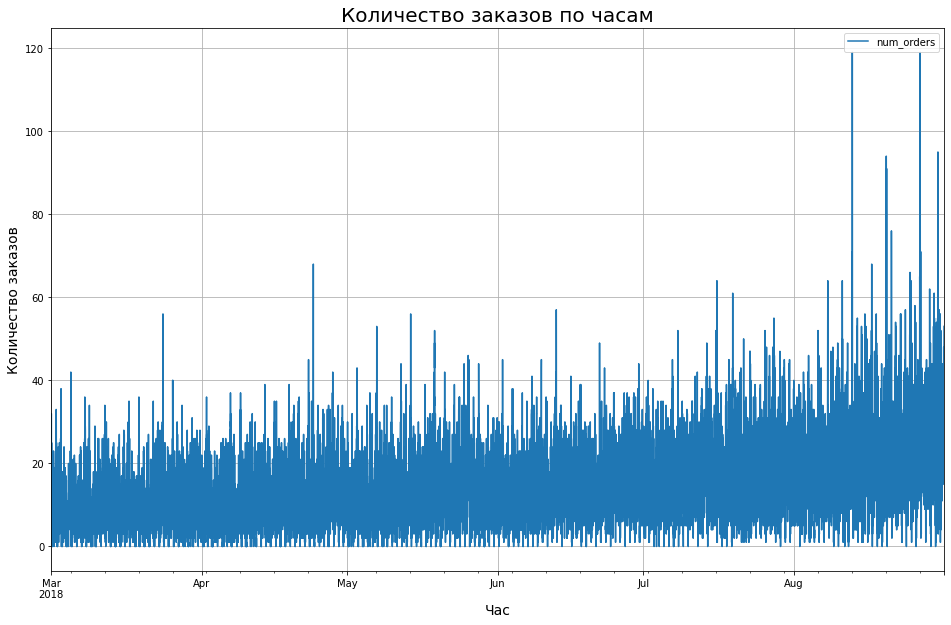

In [5]:
analysis_chart = taxi.plot(
    grid = True,
    figsize = (16, 10)
)

analysis_chart.set_title('Количество заказов по часам', fontsize=20)
analysis_chart.set_ylabel("Количество заказов", fontsize=14)
analysis_chart.set_xlabel("Час", fontsize=14);

Проведём ресемплирование данных по часу.

In [6]:
taxi_resampled = taxi.resample('1H').sum()

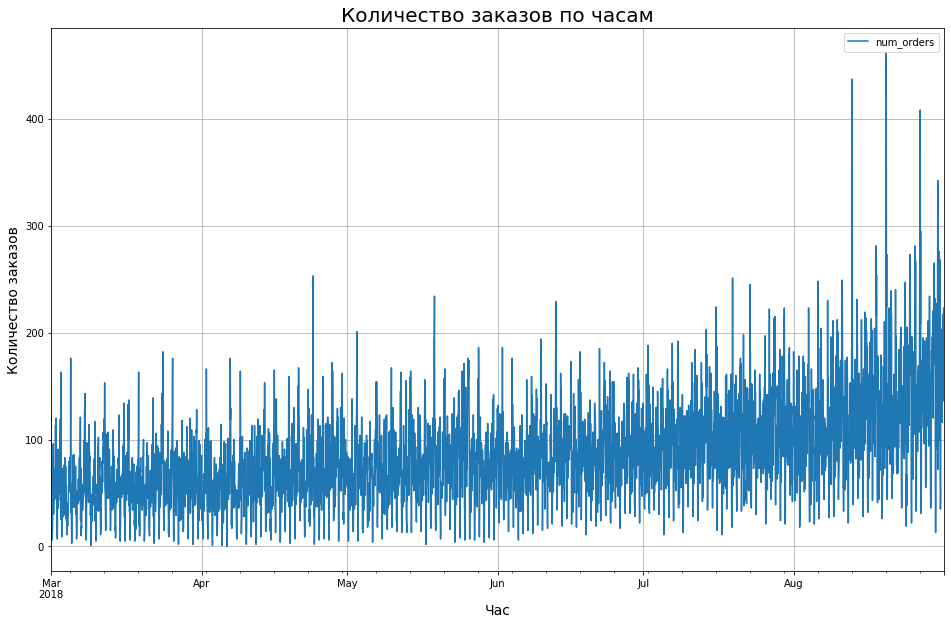

In [7]:
analysis_chart = taxi_resampled.plot(
    grid = True,
    figsize = (16, 10)
)

analysis_chart.set_title('Количество заказов по часам', fontsize=20)
analysis_chart.set_ylabel("Количество заказов", fontsize=14)
analysis_chart.set_xlabel("Час", fontsize=14);

По данным о таком длинном промежутке времени невозможно сделать выводы. Рассмотрим временной промежуток длинной в неделю и в день.

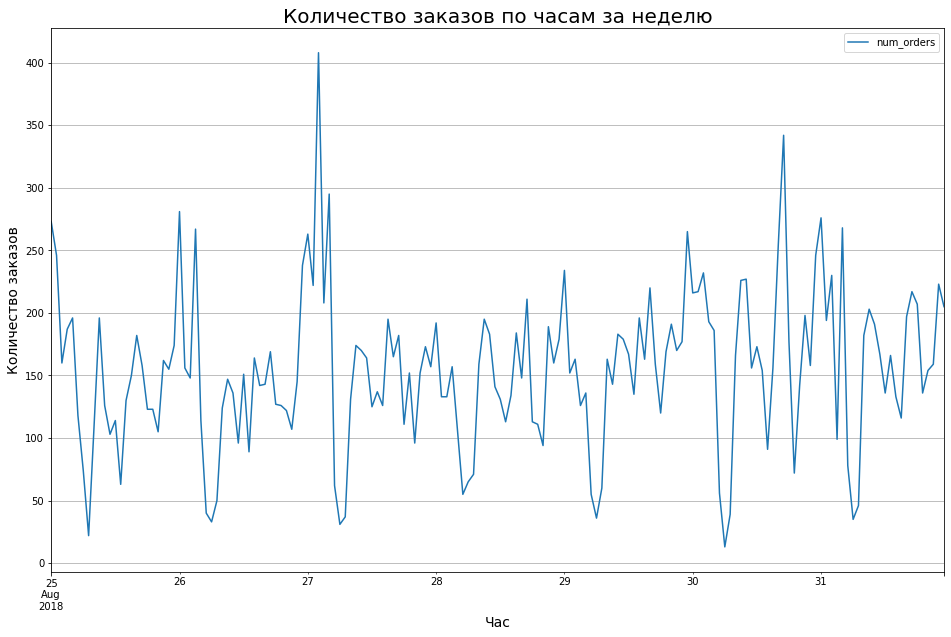

In [8]:
analysis_chart = taxi_resampled['2018-08-25':'2018-08-31'].plot(
    grid = True,
    figsize = (16, 10)
)

analysis_chart.set_title('Количество заказов по часам за неделю', fontsize=20)
analysis_chart.set_ylabel("Количество заказов", fontsize=14)
analysis_chart.set_xlabel("Час", fontsize=14);

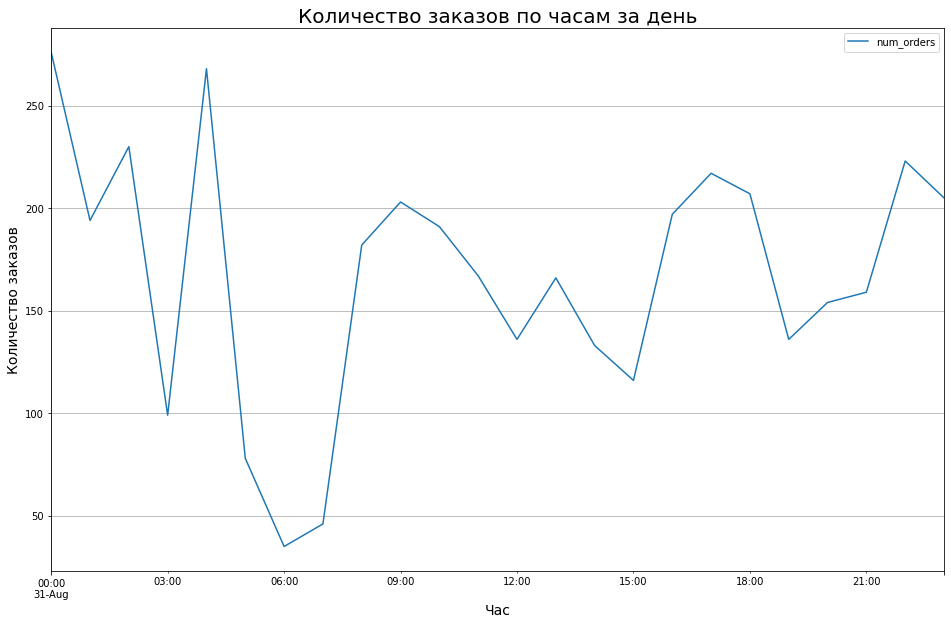

In [9]:
analysis_chart = taxi_resampled['2018-08-31 00:00:00':'2018-08-31 23:00:00'].plot(
    grid = True,
    figsize = (16, 10)
)

analysis_chart.set_title('Количество заказов по часам за день', fontsize=20)
analysis_chart.set_ylabel("Количество заказов", fontsize=14)
analysis_chart.set_xlabel("Час", fontsize=14);

По этим графикам видны еженедельные и ежедневные тренды.

Изучим тренд, сезонность и остатки данных.

In [10]:
taxi_decomposed = seasonal_decompose(taxi_resampled)

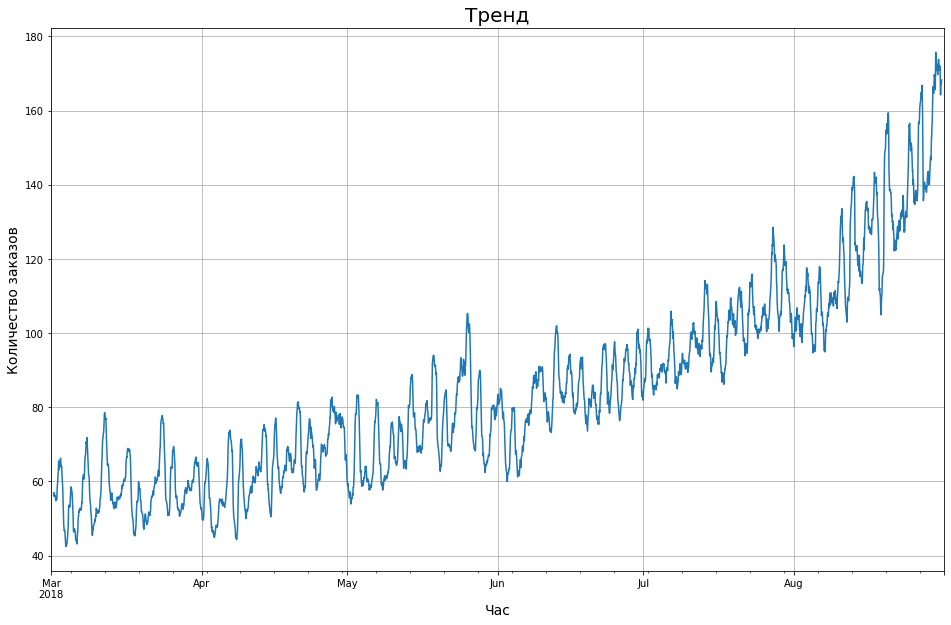

In [11]:
analysis_chart = taxi_decomposed.trend.plot(
    grid = True,
    figsize = (16, 10)
)

analysis_chart.set_title('Тренд', fontsize=20)
analysis_chart.set_ylabel("Количество заказов", fontsize=14)
analysis_chart.set_xlabel("Час", fontsize=14);

Тренд в целом понятен, общее количество пользователей компании растёт, по праздникам заметно снижение активности.

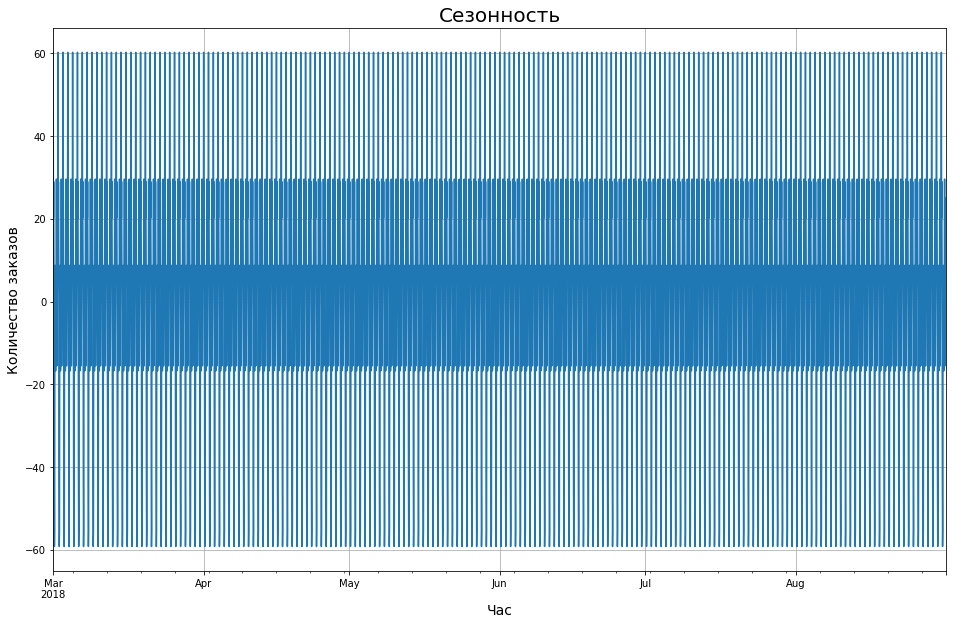

In [12]:
analysis_chart = taxi_decomposed.seasonal.plot(
    grid = True,
    figsize = (16, 10)
)

analysis_chart.set_title('Сезонность', fontsize=20)
analysis_chart.set_ylabel("Количество заказов", fontsize=14)
analysis_chart.set_xlabel("Час", fontsize=14);

По такому графику невозможно сделать точных выводов, уменьшим исследуемый промежуток до недели.

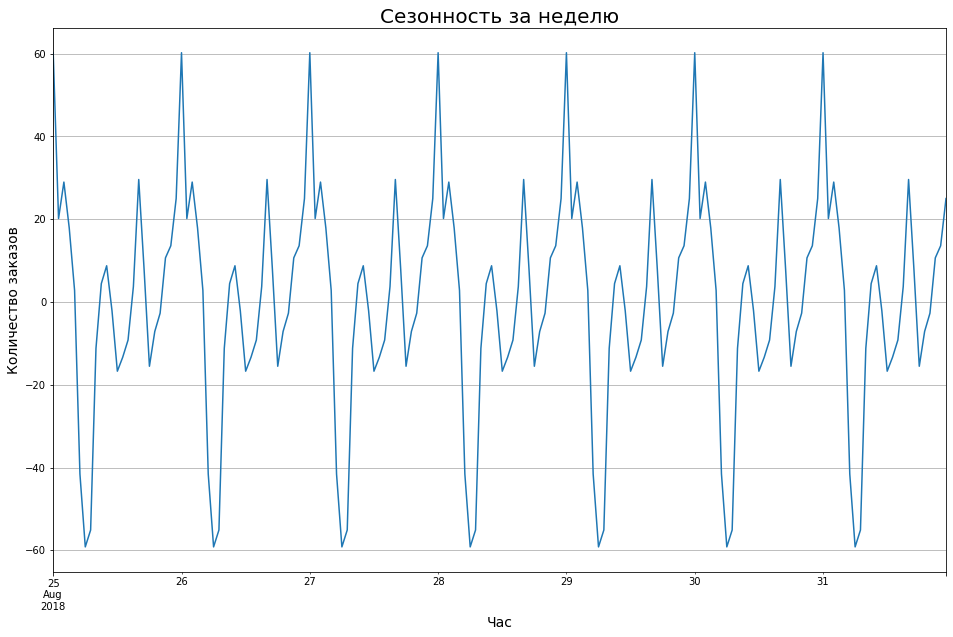

In [13]:
analysis_chart = taxi_decomposed.seasonal['2018-08-25':'2018-08-31'].plot(
    grid = True,
    figsize = (16, 10)
)

analysis_chart.set_title('Сезонность за неделю', fontsize=20)
analysis_chart.set_ylabel("Количество заказов", fontsize=14)
analysis_chart.set_xlabel("Час", fontsize=14);

Сократим промежуток до одного дня.

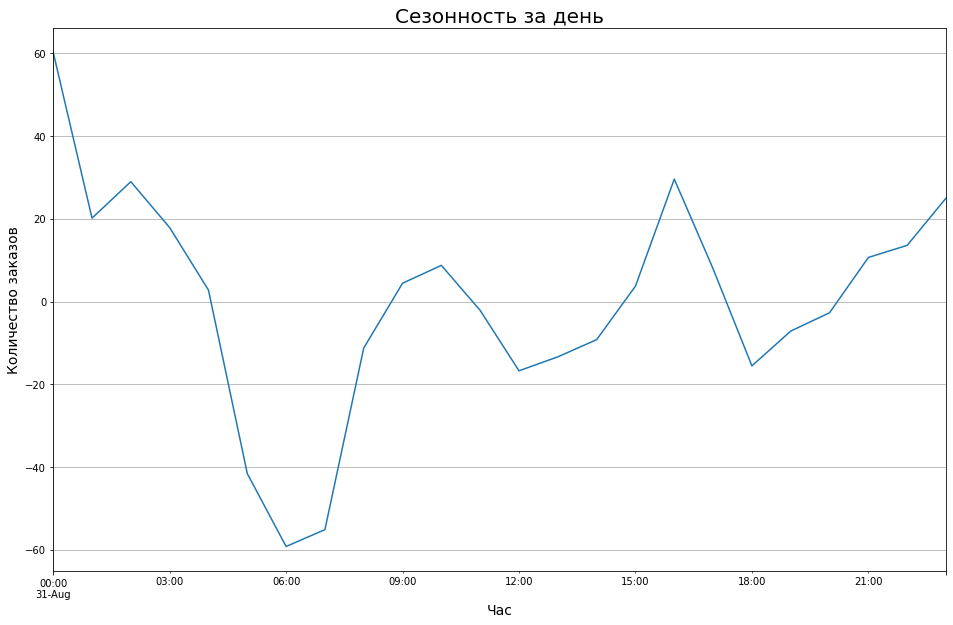

In [14]:
analysis_chart = taxi_decomposed.seasonal['2018-08-31 00:00:00':'2018-08-31 23:00:00'].plot(
    grid = True,
    figsize = (16, 10)
)

analysis_chart.set_title('Сезонность за день', fontsize=20)
analysis_chart.set_ylabel("Количество заказов", fontsize=14)
analysis_chart.set_xlabel("Час", fontsize=14);

Теперь отлично видно ежедневные изменения количества заказов. В полночь и ночью больше всего заказов, пассажиры заказывают такси, чтобы добраться до своего ночного рейса или вернуться домой из аэропорта.

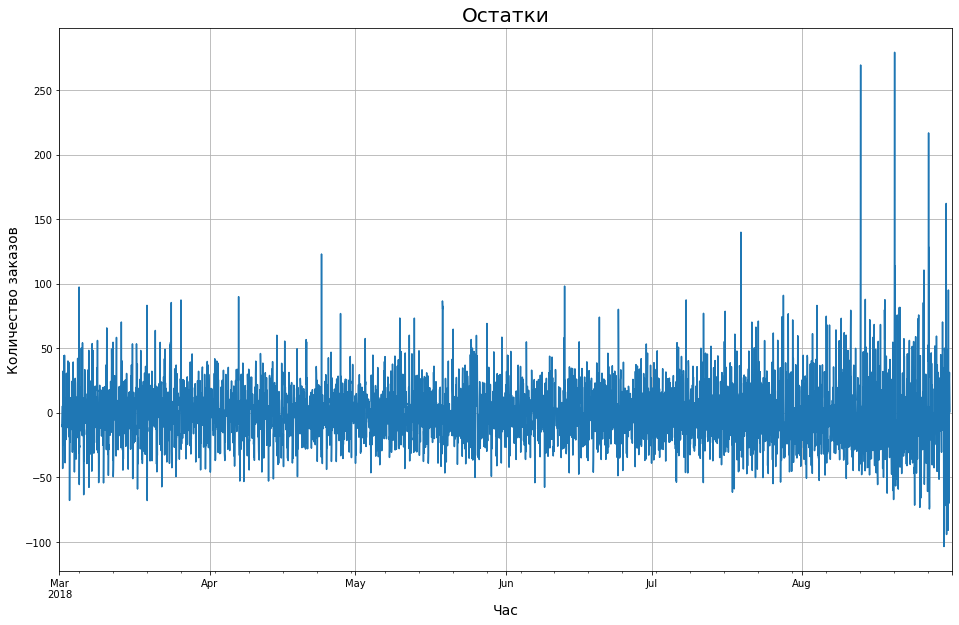

In [15]:
analysis_chart = taxi_decomposed.resid.plot(
    grid = True,
    figsize = (16, 10)
)

analysis_chart.set_title('Остатки', fontsize=20)
analysis_chart.set_ylabel("Количество заказов", fontsize=14)
analysis_chart.set_xlabel("Час", fontsize=14);

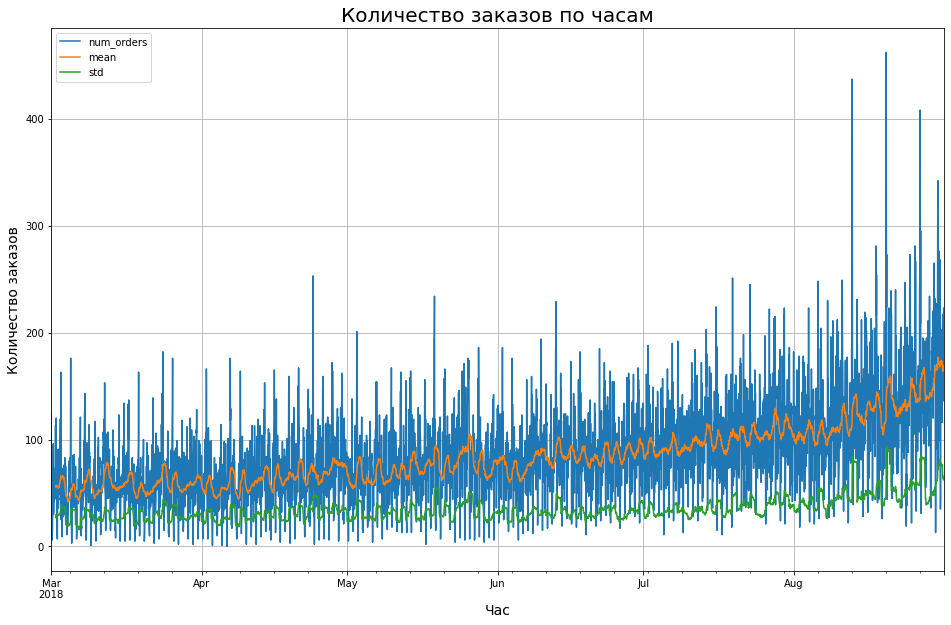

In [16]:
taxi_rolling = taxi_resampled
taxi_rolling['mean'] = taxi_rolling['num_orders'].rolling(24).mean()
taxi_rolling['std'] = taxi_rolling['num_orders'].rolling(24).std()
analysis_chart = taxi_rolling.plot(grid = True, figsize = (16, 10))

plt.title('Количество заказов по часам', fontsize=20)
plt.ylabel("Количество заказов", fontsize=14)
plt.xlabel("Час", fontsize=14);

Выводы:
- тренд растёт;
- временной ряд не является стационарным из-за растущего тренда;
- ночью количество заказов резко возрастает;
- дисперсия растёт.

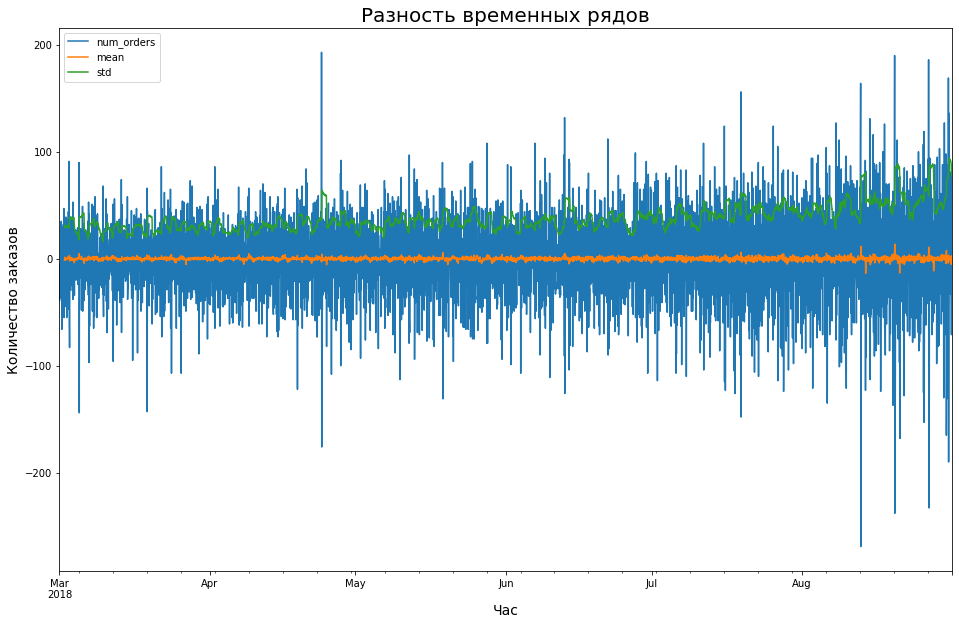

In [17]:
taxi_shift = taxi_resampled - taxi_resampled.shift()
taxi_shift['mean'] = taxi_shift['num_orders'].rolling(24, closed='left').mean()
taxi_shift['std'] = taxi_shift['num_orders'].rolling(24, closed='left').std()
taxi_shift.plot(figsize=(16, 10))

plt.title('Разность временных рядов', fontsize=20)
plt.ylabel("Количество заказов", fontsize=14)
plt.xlabel("Час", fontsize=14);

## Обучение

Будем пользоваться следующими моделями:
1. LinearRegression;
3. DecisionTreeRegressor;
4. LGBMRegressor;
5. CatBoostRegressor.

Создадим признаки для обучения моделей.

Нам понадобятся:
- dayofweek
- day
- lag

In [18]:
def make_features(data_old, max_lag, rolling_mean_size):
    data = data_old.copy()
    
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data;

Признаки создаём с значением max_lag равным 24, чтобы учесть все 24 часа дня и ежедневную сезонность, rolling_mean_size также сделаем 24, чтобы учитывать изменение тренда каждые сутки.

Создаём выборки. Тестовую выборку делаем размером 10% от исходных данных.

In [19]:
max_lag = 24
rolling_mean_size = 24

taxi_resampled = make_features(taxi_resampled, max_lag, rolling_mean_size)

features = taxi_resampled.drop('num_orders', axis=1)
target = taxi_resampled['num_orders']

In [20]:
scaler = StandardScaler()

RANDOM_STATE = 1337
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    shuffle=False,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

Масштабируем данные.

In [21]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Рассчитаем RMSE для линейной регрессии.

In [22]:
%%time

regressor = LinearRegression()

tscv = TimeSeriesSplit(n_splits=5)
    
cv_rmse_lr = GridSearchCV(regressor,
                          param_grid=[],
                          cv=tscv,
                          scoring='neg_root_mean_squared_error',
                          verbose=2,
                          n_jobs=-1)

print('Среднее значение метрики RMSE для модели LinearRegression =', cv_rmse_lr)

Среднее значение метрики RMSE для модели LinearRegression = GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(), n_jobs=-1, param_grid=[],
             scoring='neg_root_mean_squared_error', verbose=2)
CPU times: user 3.44 ms, sys: 0 ns, total: 3.44 ms
Wall time: 2.73 ms


### Рассчитаем RMSE для DecisionTreeRegressor.

In [23]:
%%time

regressor = DecisionTreeRegressor(criterion='mse', random_state=RANDOM_STATE)
params = [{'max_depth':range(2, 7)}]

print('Подбираем значение максимальной глубины дерева с наилучшим показателем метрики.\n')

clf = GridSearchCV(regressor, params, cv=tscv, scoring='neg_root_mean_squared_error')
clf.fit(X_train, y_train)

print('Значение максимальной глубины дерева с наилучшим показателем метрики:', clf.best_params_, '\n')

means = clf.cv_results_['mean_test_score']

cv_rmse_dtr = max(means) * -1
print('Среднее значение метрики RMSE для модели DecisionTreeRegressor =', cv_rmse_dtr)

Подбираем значение максимальной глубины дерева с наилучшим показателем метрики.

Значение максимальной глубины дерева с наилучшим показателем метрики: {'max_depth': 3} 

Среднее значение метрики RMSE для модели DecisionTreeRegressor = 30.26046699070912
CPU times: user 410 ms, sys: 3.43 ms, total: 413 ms
Wall time: 412 ms


### Рассчитаем RMSE для LGBMRegressor.

In [24]:
%%time

tscv = TimeSeriesSplit(n_splits=3)

regressor = LGBMRegressor(random_state=RANDOM_STATE)
params = [{'num_leaves':[50, 100, 200], 
           'learning_rate':[0.1, 0.2, 0.3]}]

print('Подбираем значения гиперпараметров с наилучшим показателем метрики.\n')

clf = GridSearchCV(regressor, params, cv=tscv, scoring='neg_root_mean_squared_error')
clf.fit(X_train, y_train)

print('Значение гиперпараметров с наилучшим показателем метрики:', clf.best_params_, '\n')

means = clf.cv_results_['mean_test_score']

cv_rmse_lgbmr = max(means) * -1
print('Среднее значение метрики RMSE для модели LGBMRegressor =', cv_rmse_lgbmr)

Подбираем значения гиперпараметров с наилучшим показателем метрики.

Значение гиперпараметров с наилучшим показателем метрики: {'learning_rate': 0.2, 'num_leaves': 50} 

Среднее значение метрики RMSE для модели LGBMRegressor = 25.916613269698615
CPU times: user 1min 30s, sys: 564 ms, total: 1min 31s
Wall time: 1min 32s


### Рассчитаем RMSE для CatBoostRegressor.

In [25]:
%%time

regressor = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
params = [{'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5]}]

print('Подбираем значения гиперпараметров с наилучшим показателем метрики.\n')

clf = GridSearchCV(regressor, params, cv=tscv, scoring='neg_root_mean_squared_error')
clf.fit(X_train, y_train)

print('Значение гиперпараметров с наилучшим показателем метрики:', clf.best_params_, '\n')

means = clf.cv_results_['mean_test_score']

cv_rmse_cbr = max(means) * -1
print('Среднее значение метрики RMSE для модели CatBoostRegressor =', cv_rmse_cbr)

Подбираем значения гиперпараметров с наилучшим показателем метрики.

Значение гиперпараметров с наилучшим показателем метрики: {'learning_rate': 0.1} 

Среднее значение метрики RMSE для модели CatBoostRegressor = 24.799566795127035
CPU times: user 1min 15s, sys: 1.32 s, total: 1min 17s
Wall time: 1min 28s


Вывод: Мы изучили четыре модели, подобрали для них лучшие гиперпараметры и рассчитали метрику RMSE на кросс-валидации. На кросс-валидации лучше всего себя показала модель CatBoostRegressor.

## Тестирование

Проверим модель CatBoostRegressor на тестовой выборке.

In [26]:
%%time

regressor = LGBMRegressor(learning_rate=0.2, num_leaves=200, random_state=RANDOM_STATE)
regressor.fit(X_train, y_train)

CPU times: user 6.45 s, sys: 51.6 ms, total: 6.5 s
Wall time: 6.58 s


LGBMRegressor(learning_rate=0.2, num_leaves=200, random_state=1337)

In [27]:
%%time

y_pred = regressor.predict(X_test)

CPU times: user 21.9 ms, sys: 3.89 ms, total: 25.8 ms
Wall time: 4.91 ms


In [28]:
rmse_lgbmr = mean_squared_error(y_test, y_pred, squared=False)
print(rmse_lgbmr)

42.64679268543179


Найдём значение метрики RMSE на модели-болванке DummyRegressor.

In [29]:
dummy_reg = DummyRegressor()
dummy_reg.fit(X_train, y_train)
y_test_pred_dummy = dummy_reg.predict(X_test)

rmse_dummy = mean_squared_error(y_test, y_test_pred_dummy, squared=False)
print('Значение метрики RMSE на модели-болванке =', rmse_dummy)

Значение метрики RMSE на модели-болванке = 84.74414402014742


In [30]:
if rmse_lgbmr > rmse_dummy:
    print(f'Значение метрики RMSE на модели-болванке {rmse_dummy} показывает лучший результат.')
else:
    print(f'Значение метрики RMSE на подобранной модели {rmse_lgbmr} показывает лучший результат.')

if rmse_lgbmr > 48:
    print(f'Значение метрики RMSE {rmse_lgbmr} не удовлетворяет критерию успеха.')
else:
    print(f'Значение метрики RMSE {rmse_lgbmr} удовлетворяет критерию успеха.')

Значение метрики RMSE на подобранной модели 42.64679268543179 показывает лучший результат.
Значение метрики RMSE 42.64679268543179 удовлетворяет критерию успеха.


Значение метрики RMSE 42.64679268543179 не превышает требуемый порог в 48, так что такой результат считаем приемлимым. Значение метрики на тестовой стало хуже чем на кросс-валидации, что говорит о переобучении модели.

# Вывод:

Во время работы было выполнено четыре шага:
1. Предобработка;
2. Анализ данных;
2. Обучение моделей;
3. Применение модели и анализ результатов.

В процессе предобработки признак *datetime* был сделан индексом и была проверена монотонность индексов.

В процессе анализа были изучены тренд, сезонность и остатки, а также построены их графики.

В процессе обучения моделей были добавлены новые признаки: month, dayofweek, day, lag и rolling_mean. Признаки были разбиты на тренировочную и тестовую выборки и масшатбированы. На основе тренировочной выборки для четырёх выбранных моделей, LinearRegression, DecisionTreeRegressor, LGBMRegressor и CatBoostRegressor, были рассчитаны наилучшие гиперпараметры и рассчитана метрика RMSE на кросс-валидации.

Лучшие результаты показали модели градиентного бустинга, LGBMRegressor и CatBoostRegressor. Их результаты были близки, 25.916613269698615 и 24.799566795127035, соответственно. Они работали медленнее моделей линейной регрессии и дерева регрессии, однако показали значительно лучшие значения метрики RMSE.

Лучшие результаты на кросс-валидации показали модели градиентного бустинга, они смогли показать хорошее время и точность. Второй по качеству можно считать модель DecisionTreeRegressor, которая показала схожие по качеству с LGBMRegressor результаты с отличием в 18%, но за время меньшее в 43,5 раза. Модель LGBMRegressor оказалась чуть точнее чем CatBoostRegressor, поэтому для проверки на тестовой выборке будем применять её.

После применения модели была повторно рассчитана метрика RMSE, также было рассчитано время предсказания и обучения модели. Значение метрики не превышает значение на модели-болванке и не превышает требуемый порог в 48, так что такой результат считаем приемлимым, однако оно ухудшилось в сравнении с кросс-валидацией и теперь составляет 42.64679268543179, что может говорить о переобучении модели.